<a href="https://colab.research.google.com/github/gKorada/MLPractice/blob/main/CrimeAnalysisUsingSpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crime Type Classification

In [ ]:
#session.stop()

In [ ]:
#import wget
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import HiveContext
from pyspark.sql import Row

from pyspark.sql import SparkSession

In [ ]:

session=SparkSession.builder.appName("Multi class classificationexample").master("local").config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()
data=session.read.csv("Crime_Data_from_2020_to_Present_20250510.csv", header=True, inferSchema=True)

In [ ]:
data.show(5, truncate=False)

print("Before cleansing:", data.count())

+---------+----------------------+----------------------+--------+----+-----------+-----------+--------+------+-----------------+------------------------+--------+--------+------------+---------+----------------------+--------------+----------------------------------------------+------+-----------+--------+--------+--------+--------+---------------------------------------+-------------------------------+-------+---------+
|DR_NO    |Date Rptd             |DATE OCC              |TIME OCC|AREA|AREA NAME  |Rpt Dist No|Part 1-2|Crm Cd|Crm Cd Desc      |Mocodes                 |Vict Age|Vict Sex|Vict Descent|Premis Cd|Premis Desc           |Weapon Used Cd|Weapon Desc                                   |Status|Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|LOCATION                               |Cross Street                   |LAT    |LON      |
+---------+----------------------+----------------------+--------+----+-----------+-----------+--------+------+-----------------+-------------------

In [ ]:
data = data.dropna(subset=["Crm Cd Desc", "DATE OCC", "TIME OCC", "LAT", "LON", "Vict Age", "Vict Sex", "Vict Descent"])

In [ ]:
from pyspark.sql.functions import when

data = data.fillna({"Weapon Desc": "Unknown", "Premis Desc": "Unknown", "Mocodes": "Unknown"})

In [ ]:
print("After cleaning:", data.count())

After cleaning: 307056


In [ ]:
data.columns

['DR_NO',
 'Date Rptd',
 'DATE OCC',
 'TIME OCC',
 'AREA',
 'AREA NAME',
 'Rpt Dist No',
 'Part 1-2',
 'Crm Cd',
 'Crm Cd Desc',
 'Mocodes',
 'Vict Age',
 'Vict Sex',
 'Vict Descent',
 'Premis Cd',
 'Premis Desc',
 'Weapon Used Cd',
 'Weapon Desc',
 'Status',
 'Status Desc',
 'Crm Cd 1',
 'Crm Cd 2',
 'Crm Cd 3',
 'Crm Cd 4',
 'LOCATION',
 'Cross Street',
 'LAT',
 'LON']

In [ ]:
# copy or duplicate data
mcc_data = data

In [ ]:
mcc_data.show(5, truncate=False)

+---------+----------------------+----------------------+--------+----+-----------+-----------+--------+------+-----------------+-----------------------------+--------+--------+------------+---------+--------------------------------------------+--------------+----------------------------------------------+------+-----------+--------+--------+--------+--------+---------------------------------------+-------------------------------+-------+---------+
|DR_NO    |Date Rptd             |DATE OCC              |TIME OCC|AREA|AREA NAME  |Rpt Dist No|Part 1-2|Crm Cd|Crm Cd Desc      |Mocodes                      |Vict Age|Vict Sex|Vict Descent|Premis Cd|Premis Desc                                 |Weapon Used Cd|Weapon Desc                                   |Status|Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|LOCATION                               |Cross Street                   |LAT    |LON      |
+---------+----------------------+----------------------+--------+----+-----------+-----------

In [ ]:
'''
Drop
DR_NO
Unique ID – no predictive value
Date Rptd
When it was reported – may be inconsistent with occurrence date
Crm Cd
Same as target Crm Cd Desc in coded form – leaks the answer
Crm Cd 1-4
These are codes for other crimes, including the main one – leak target
Crm Cd Desc
✅ Keep this only as the TARGET, drop it from features
Status
Not known at time of crime – backward leakage
Status Desc
Same as above
LOCATION
Full address – high cardinality, privacy-protected, not meaningful
Cross Street
Often null, high cardinality
Rpt Dist No
Very granular geo code – optional, could cause overfitting
'''

mcc_data = mcc_data.drop("DR_NO", "Date Rptd", "Crm Cd", "Crm Cd 1", "Crm Cd 2", "Crm Cd 3", "Crm Cd 4",
                        "Mocodes", "Status", "Status Desc", "LOCATION", "Cross Street", "Rpt Dist No")
mcc_data.show(5, truncate=False)

+----------------------+--------+----+-----------+--------+-----------------+--------+--------+------------+---------+--------------------------------------------+--------------+----------------------------------------------+-------+---------+
|DATE OCC              |TIME OCC|AREA|AREA NAME  |Part 1-2|Crm Cd Desc      |Vict Age|Vict Sex|Vict Descent|Premis Cd|Premis Desc                                 |Weapon Used Cd|Weapon Desc                                   |LAT    |LON      |
+----------------------+--------+----+-----------+--------+-----------------+--------+--------+------------+---------+--------------------------------------------+--------------+----------------------------------------------+-------+---------+
|02/01/2020 12:00:00 AM|1700    |21  |Topanga    |2       |EXTORTION        |23      |F       |W           |103      |ALLEY                                       |NULL          |Unknown                                       |34.1938|-118.571 |
|01/08/2020 12:00:00 AM|

In [ ]:
from pyspark.sql.functions import col, lpad

# Pad the time with zeros to ensure it’s 4 digits (e.g., 900 -> 0900)
mcc_data = mcc_data.withColumn("time_occ_padded", lpad(col("TIME OCC").cast("string"), 4, "0"))

# Extract hour
mcc_data = mcc_data.withColumn("hour", col("time_occ_padded").substr(1, 2).cast("int"))

# Optional: create a binary feature for Night (1) vs Day (0) — night = 8 PM to 6 AM
mcc_data = mcc_data.withColumn("is_night", ((col("hour") >= 20) | (col("hour") < 6)).cast("int"))

In [ ]:
from pyspark.sql.functions import to_date, month, dayofweek
session.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Convert to Spark date
mcc_data = mcc_data.withColumn("date_occ_date", to_date(col("DATE OCC"), "MM/dd/yyyy"))

# Extract month and day of week (1 = Sunday, 7 = Saturday)
mcc_data = mcc_data.withColumn("month", month(col("date_occ_date")))
mcc_data = mcc_data.withColumn("day_of_week", dayofweek(col("date_occ_date")))

In [ ]:
from pyspark.sql.functions import when

mcc_data = mcc_data.withColumn("vict_age_group",
    when(col("Vict Age") < 18, "Under 18")
    .when((col("Vict Age") >= 18) & (col("Vict Age") <= 35), "18-35")
    .when((col("Vict Age") > 35) & (col("Vict Age") <= 65), "36-65")
    .when(col("Vict Age") > 65, "65+")
    .otherwise("Unknown")
)

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# Drop rows with null or invalid lat/lon (e.g., (0.0, 0.0))
df_geo = mcc_data.filter((col("LAT").isNotNull()) & (col("LON").isNotNull()) &
                   (~((col("LAT") == 0.0) & (col("LON") == 0.0))))

# Assemble features
geo_assembler = VectorAssembler(inputCols=["LAT", "LON"], outputCol="geo_features")
df_geo_vec = geo_assembler.transform(df_geo)

# Train KMeans (you can tune k = number of zones)
kmeans = KMeans(featuresCol="geo_features", predictionCol="geo_cluster", k=10)
model = kmeans.fit(df_geo_vec)

# Add cluster to original dataframe
df_geo_clustered = model.transform(df_geo_vec)

# Join back to main df if needed (left join on DR_NO or other unique ID)

In [ ]:
df_geo_clustered.show(5, truncate=False)

+----------------------+--------+----+-----------+--------+-----------------+--------+--------+------------+---------+--------------------------------------------+--------------+----------------------------------------------+-------+---------+---------------+----+--------+-------------+-----+-----------+--------------+-------------------+-----------+
|DATE OCC              |TIME OCC|AREA|AREA NAME  |Part 1-2|Crm Cd Desc      |Vict Age|Vict Sex|Vict Descent|Premis Cd|Premis Desc                                 |Weapon Used Cd|Weapon Desc                                   |LAT    |LON      |time_occ_padded|hour|is_night|date_occ_date|month|day_of_week|vict_age_group|geo_features       |geo_cluster|
+----------------------+--------+----+-----------+--------+-----------------+--------+--------+------------+---------+--------------------------------------------+--------------+----------------------------------------------+-------+---------+---------------+----+--------+-------------+-----+-

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

# === Step 1: Index Categorical Columns ===
indexers = [
    StringIndexer(inputCol=col, outputCol=col+"_idx", handleInvalid="keep") for col in [
        "Vict Sex", "Vict Descent", "Premis Desc", "Weapon Desc", "vict_age_group", "AREA NAME"
    ]
]

# === Step 2: One-Hot Encode Indexed Columns ===
encoders = [
    OneHotEncoder(inputCol=col+"_idx", outputCol=col+"_ohe") for col in [
        "Vict Sex", "Vict Descent", "Premis Desc", "Weapon Desc", "vict_age_group", "AREA NAME"
    ]
]

# === Step 3: Label Indexer ===
label_indexer = StringIndexer(inputCol="Crm Cd Desc", outputCol="label", handleInvalid="skip")

# === Step 4: Vector Assembler ===
assembler = VectorAssembler(
    inputCols=[
        "hour", "is_night", "month", "day_of_week",
        "geo_cluster",
        "Vict Sex_ohe", "Vict Descent_ohe", "Premis Desc_ohe",
        "Weapon Desc_ohe", "vict_age_group_ohe", "AREA NAME_ohe"
    ],
    outputCol="features"
)

# === Step 5: Model ===
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)

# === Step 6: Pipeline ===
pipeline = Pipeline(stages=indexers + encoders + [label_indexer, assembler, rf])

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 80/20 split
train_data, test_data = df_geo_clustered.randomSplit([0.8, 0.2], seed=42)

# Train the model

model = pipeline.fit(train_data)
predictions = model.transform(test_data)



In [ ]:
# Evaluate the model
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

f1_score = evaluator_f1.evaluate(predictions)
print("Test Set F1 Score =", f1_score)

accuracy = evaluator_accuracy.evaluate(predictions)
print("Test Set Accuracy =", accuracy)

precision = evaluator_precision.evaluate(predictions)
print("Test Set Precision =", precision)

recall = evaluator_recall.evaluate(predictions)
print("Test Set Recall =", recall)

Test Set F1 Score = 0.24173863539090604
Test Set Accuracy = 0.35474120419273586
Test Set Precision = 0.33713799048243126
Test Set Recall = 0.35474120419273586


In [ ]:
mcc_data.groupBy("Crm Cd Desc").count().orderBy("count", ascending=False).show(30, truncate=False)

+--------------------------------------------------------+-----+
|Crm Cd Desc                                             |count|
+--------------------------------------------------------+-----+
|BATTERY - SIMPLE ASSAULT                                |24371|
|BURGLARY FROM VEHICLE                                   |23256|
|THEFT OF IDENTITY                                       |22911|
|VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) |21317|
|THEFT PLAIN - PETTY ($950 & UNDER)                      |20676|
|SHOPLIFTING - PETTY THEFT ($950 & UNDER)                |19195|
|BURGLARY                                                |19034|
|ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT          |16420|
|THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)     |14754|
|THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD|14460|
|INTIMATE PARTNER - SIMPLE ASSAULT                       |14060|
|ROBBERY                                                 |10129|
|TRESPASSING             

In [ ]:
from pyspark.sql.functions import col

# Define the top 10 crime types
top_crimes = [
    "BATTERY - SIMPLE ASSAULT",
    "BURGLARY FROM VEHICLE",
    "THEFT OF IDENTITY",
    "VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)",
    "THEFT PLAIN - PETTY ($950 & UNDER)",
    "SHOPLIFTING - PETTY THEFT ($950 & UNDER)",
    "BURGLARY",
    "ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",
    "THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)",
    "THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD"
]

# Filter the main DataFrame
filtered_data = df_geo_clustered.filter(col("Crm Cd Desc").isin(top_crimes))

In [ ]:
from pyspark.sql.functions import to_timestamp, col
subset_data = filtered_data.sample(withReplacement=False, fraction=0.05, seed=42)
subset_data = subset_data.withColumn("parsed_date", to_timestamp("DATE OCC", "MM/dd/yyyy hh:mm:ss a"))

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Add StringIndexer and OneHotEncoder for geo_cluster
geo_indexer = StringIndexer(inputCol="geo_cluster", outputCol="geo_cluster_idx")
geo_encoder = OneHotEncoder(inputCol="geo_cluster_idx", outputCol="geo_cluster_ohe")


# Index categorical features
indexers = [
    StringIndexer(inputCol=col, outputCol=col+"_idx", handleInvalid="keep") for col in [
        "Vict Sex", "Vict Descent", "Premis Desc", "Weapon Desc", "vict_age_group", "AREA NAME"
    ]
]

# One-hot encode them
encoders = [
    OneHotEncoder(inputCol=col+"_idx", outputCol=col+"_ohe") for col in [
        "Vict Sex", "Vict Descent", "Premis Desc", "Weapon Desc", "vict_age_group", "AREA NAME"
    ]
]


label_indexer = StringIndexer(inputCol="Crm Cd Desc", outputCol="label", handleInvalid="skip")

assembler = VectorAssembler(
    inputCols=[
    "hour", "is_night", "month", "day_of_week",
    "Vict Sex_ohe", "Vict Descent_ohe", "Premis Desc_ohe",
    "Weapon Desc_ohe", "vict_age_group_ohe", "AREA NAME_ohe",
    "geo_cluster_ohe"
  ],
    outputCol="features"
)

label_converter = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=label_indexer.fit(subset_data).labels)


rf = RandomForestClassifier()
pipeline = Pipeline(stages=indexers + encoders + [geo_indexer, geo_encoder, label_indexer, assembler, rf, label_converter])




# ParamGridBuilder for Random Forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [8, 12]) \
    .addGrid(rf.numTrees, [50]) \
    .build()
#    .addGrid(rf.maxBins, [32, 64]) \
#    .addGrid(rf.numTrees, [50, 100]) \
#    .addGrid(rf.minInstancesPerNode, [1, 5]) \
#    .addGrid(rf.featureSubsetStrategy, ["auto", "sqrt", "log2"]) \
#    .addGrid(rf.impurity, ["gini", "entropy"]) \
 #   .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)  # use 3+ folds in practice

subset_data = subset_data.withColumn("parsed_date", to_timestamp("DATE OCC", "MM/dd/yyyy hh:mm:ss a"))
subset_data = subset_data.filter(col("parsed_date").isNotNull())

#Splitting the dataset in training and test
training, test=subset_data.randomSplit([0.8,0.2],seed=123)

#Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(training)

#Predicting the results on test dataset
cvresults=cvModel.transform(test)

#Displaying the results
cvresults.show(2, truncate=False)

# Evaluate the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

print("F1 Score:", evaluator_f1.evaluate(cvresults))
print("Accuracy:", evaluator_acc.evaluate(cvresults))
print("Precision:", evaluator_precision.evaluate(cvresults))
print("Recall:", evaluator_recall.evaluate(cvresults))

from pyspark.sql.functions import col, when

rec_mapping_expr = when(col("predicted_label") == "BATTERY - SIMPLE ASSAULT", "Conflict de-escalation training or neighborhood watch") \
    .when(col("predicted_label") == "BURGLARY FROM VEHICLE", "Motion-sensor lighting and parking CCTV") \
    .when(col("predicted_label") == "THEFT OF IDENTITY", "Digital hygiene and identity protection awareness") \
    .when(col("predicted_label") == "VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)", "Use plexiglass and graffiti-resistant materials") \
    .when(col("predicted_label") == "THEFT PLAIN - PETTY ($950 & UNDER)", "Install secured displays and train employees") \
    .when(col("predicted_label") == "SHOPLIFTING - PETTY THEFT ($950 & UNDER)", "Anti-theft sensors and floor surveillance") \
    .when(col("predicted_label") == "BURGLARY", "Install security alarms and reinforce doors/windows") \
    .when(col("predicted_label") == "ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT", "Deploy emergency response systems and patrol units") \
    .when(col("predicted_label") == "THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)", "Install car surveillance systems and educate on valuables") \
    .when(col("predicted_label") == "THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD", "Use alarmed storage and track high-value assets") \
    .otherwise("General awareness and prevention strategies")

cvresults_with_action = cvresults.withColumn("recommended_action", rec_mapping_expr)
cvresults_with_action.select("geo_cluster", "predicted_label", "recommended_action").show(10, truncate=False)


AssertionError: 

In [ ]:
from pyspark.sql.functions import to_timestamp, col
subset_data = filtered_data.sample(withReplacement=False, fraction=0.05, seed=42)
subset_data = subset_data.withColumn("parsed_date", to_timestamp("DATE OCC", "MM/dd/yyyy hh:mm:ss a"))

In [ ]:
# Fit your feature pipeline up to assembler
feature_pipeline = Pipeline(stages=indexers + encoders + [geo_indexer, geo_encoder, label_indexer, assembler])
feature_model = feature_pipeline.fit(subset_data)

# Transform a sample row to get actual vector size
feature_df = feature_model.transform(subset_data)
sample_vector = feature_df.select("features").limit(1).collect()[0]["features"]
true_input_size = sample_vector.size

# Count output classes
true_output_size = feature_df.select("label").distinct().count()

print("✅ True input size:", true_input_size)
print("✅ True output size:", true_output_size)



In [ ]:
subset_data.show(2)

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, IndexToString
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Index categorical features
indexers = [
    StringIndexer(inputCol=col, outputCol=col+"_idx", handleInvalid="keep") for col in [
        "Vict Sex", "Vict Descent", "Premis Desc", "Weapon Desc", "vict_age_group", "AREA NAME"
    ]
]

# One-hot encode them
encoders = [
    OneHotEncoder(inputCol=col+"_idx", outputCol=col+"_ohe") for col in [
        "Vict Sex", "Vict Descent", "Premis Desc", "Weapon Desc", "vict_age_group", "AREA NAME"
    ]
]

# geo clustering
geo_indexer = StringIndexer(inputCol="geo_cluster", outputCol="geo_cluster_idx")
geo_encoder = OneHotEncoder(inputCol="geo_cluster_idx", outputCol="geo_cluster_ohe")

# label indexer
label_indexer = StringIndexer(inputCol="Crm Cd Desc", outputCol="label", handleInvalid="skip")

# Assemble features
assembler = VectorAssembler(
    inputCols=[
        "hour", "is_night", "month", "day_of_week",
        "Vict Sex_ohe", "Vict Descent_ohe", "Premis Desc_ohe",
        "Weapon Desc_ohe", "vict_age_group_ohe", "AREA NAME_ohe",
        "geo_cluster_ohe"
    ],
    outputCol="features"
)

# Fit preprocessing pipeline to training data to compute consistent input size
preprocessing_pipeline = Pipeline(stages=indexers + encoders + [geo_indexer, geo_encoder, label_indexer, assembler])
preprocessing_model = preprocessing_pipeline.fit(subset_data)
preprocessed_data = preprocessing_model.transform(subset_data)

# Split after transformation
training, test = preprocessed_data.randomSplit([0.8, 0.2], seed=123)

# Compute input and output size
input_size = training.select("features").first()["features"].size
output_size = training.select("label").distinct().count()

# Define MLP model
mlp = MultilayerPerceptronClassifier(
    labelCol="label",
    featuresCol="features",
    layers=[input_size, 128, 64, output_size],
    maxIter=100,
    seed=123
)

# Build final pipeline with label converter
label_converter = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=preprocessing_model.stages[-2].labels)
final_pipeline = Pipeline(stages=[mlp, label_converter])

# Fit & predict
model = final_pipeline.fit(training)
cvresults = model.transform(test)

# Evaluate
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print("F1 Score:", evaluator.evaluate(cvresults, {evaluator.metricName: "f1"}))
print("Accuracy:", evaluator.evaluate(cvresults, {evaluator.metricName: "accuracy"}))
print("Precision:", evaluator.evaluate(cvresults, {evaluator.metricName: "weightedPrecision"}))
print("Recall:", evaluator.evaluate(cvresults, {evaluator.metricName: "weightedRecall"}))

cvresults.select("predicted_label", "Crm Cd Desc", "geo_cluster").show(10, truncate=False)

from pyspark.sql.functions import col, when

rec_mapping_expr = when(col("predicted_label") == "BATTERY - SIMPLE ASSAULT", "Conflict de-escalation training or neighborhood watch") \
    .when(col("predicted_label") == "BURGLARY FROM VEHICLE", "Motion-sensor lighting and parking CCTV") \
    .when(col("predicted_label") == "THEFT OF IDENTITY", "Digital hygiene and identity protection awareness") \
    .when(col("predicted_label") == "VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)", "Use plexiglass and graffiti-resistant materials") \
    .when(col("predicted_label") == "THEFT PLAIN - PETTY ($950 & UNDER)", "Install secured displays and train employees") \
    .when(col("predicted_label") == "SHOPLIFTING - PETTY THEFT ($950 & UNDER)", "Anti-theft sensors and floor surveillance") \
    .when(col("predicted_label") == "BURGLARY", "Install security alarms and reinforce doors/windows") \
    .when(col("predicted_label") == "ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT", "Deploy emergency response systems and patrol units") \
    .when(col("predicted_label") == "THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)", "Install car surveillance systems and educate on valuables") \
    .when(col("predicted_label") == "THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD", "Use alarmed storage and track high-value assets") \
    .otherwise("General awareness and prevention strategies")

cvresults_with_action = cvresults.withColumn("recommended_action", rec_mapping_expr)
cvresults_with_action.select("geo_cluster", "predicted_label", "recommended_action").show(10, truncate=False)


F1 Score: 0.5107929742540418
Accuracy: 0.5515853044791142
Precision: 0.4982155241475319
Recall: 0.5515853044791141
+-------------------------------------------------------+--------------------------------------------------------+-----------+
|predicted_label                                        |Crm Cd Desc                                             |geo_cluster|
+-------------------------------------------------------+--------------------------------------------------------+-----------+
|THEFT OF IDENTITY                                      |THEFT OF IDENTITY                                       |9          |
|THEFT OF IDENTITY                                      |THEFT OF IDENTITY                                       |0          |
|BURGLARY                                               |THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD|7          |
|THEFT OF IDENTITY                                      |THEFT OF IDENTITY                                       |0        

In [ ]:
!pip install sparkxgb

In [ ]:
!pip install contextily --upgrade

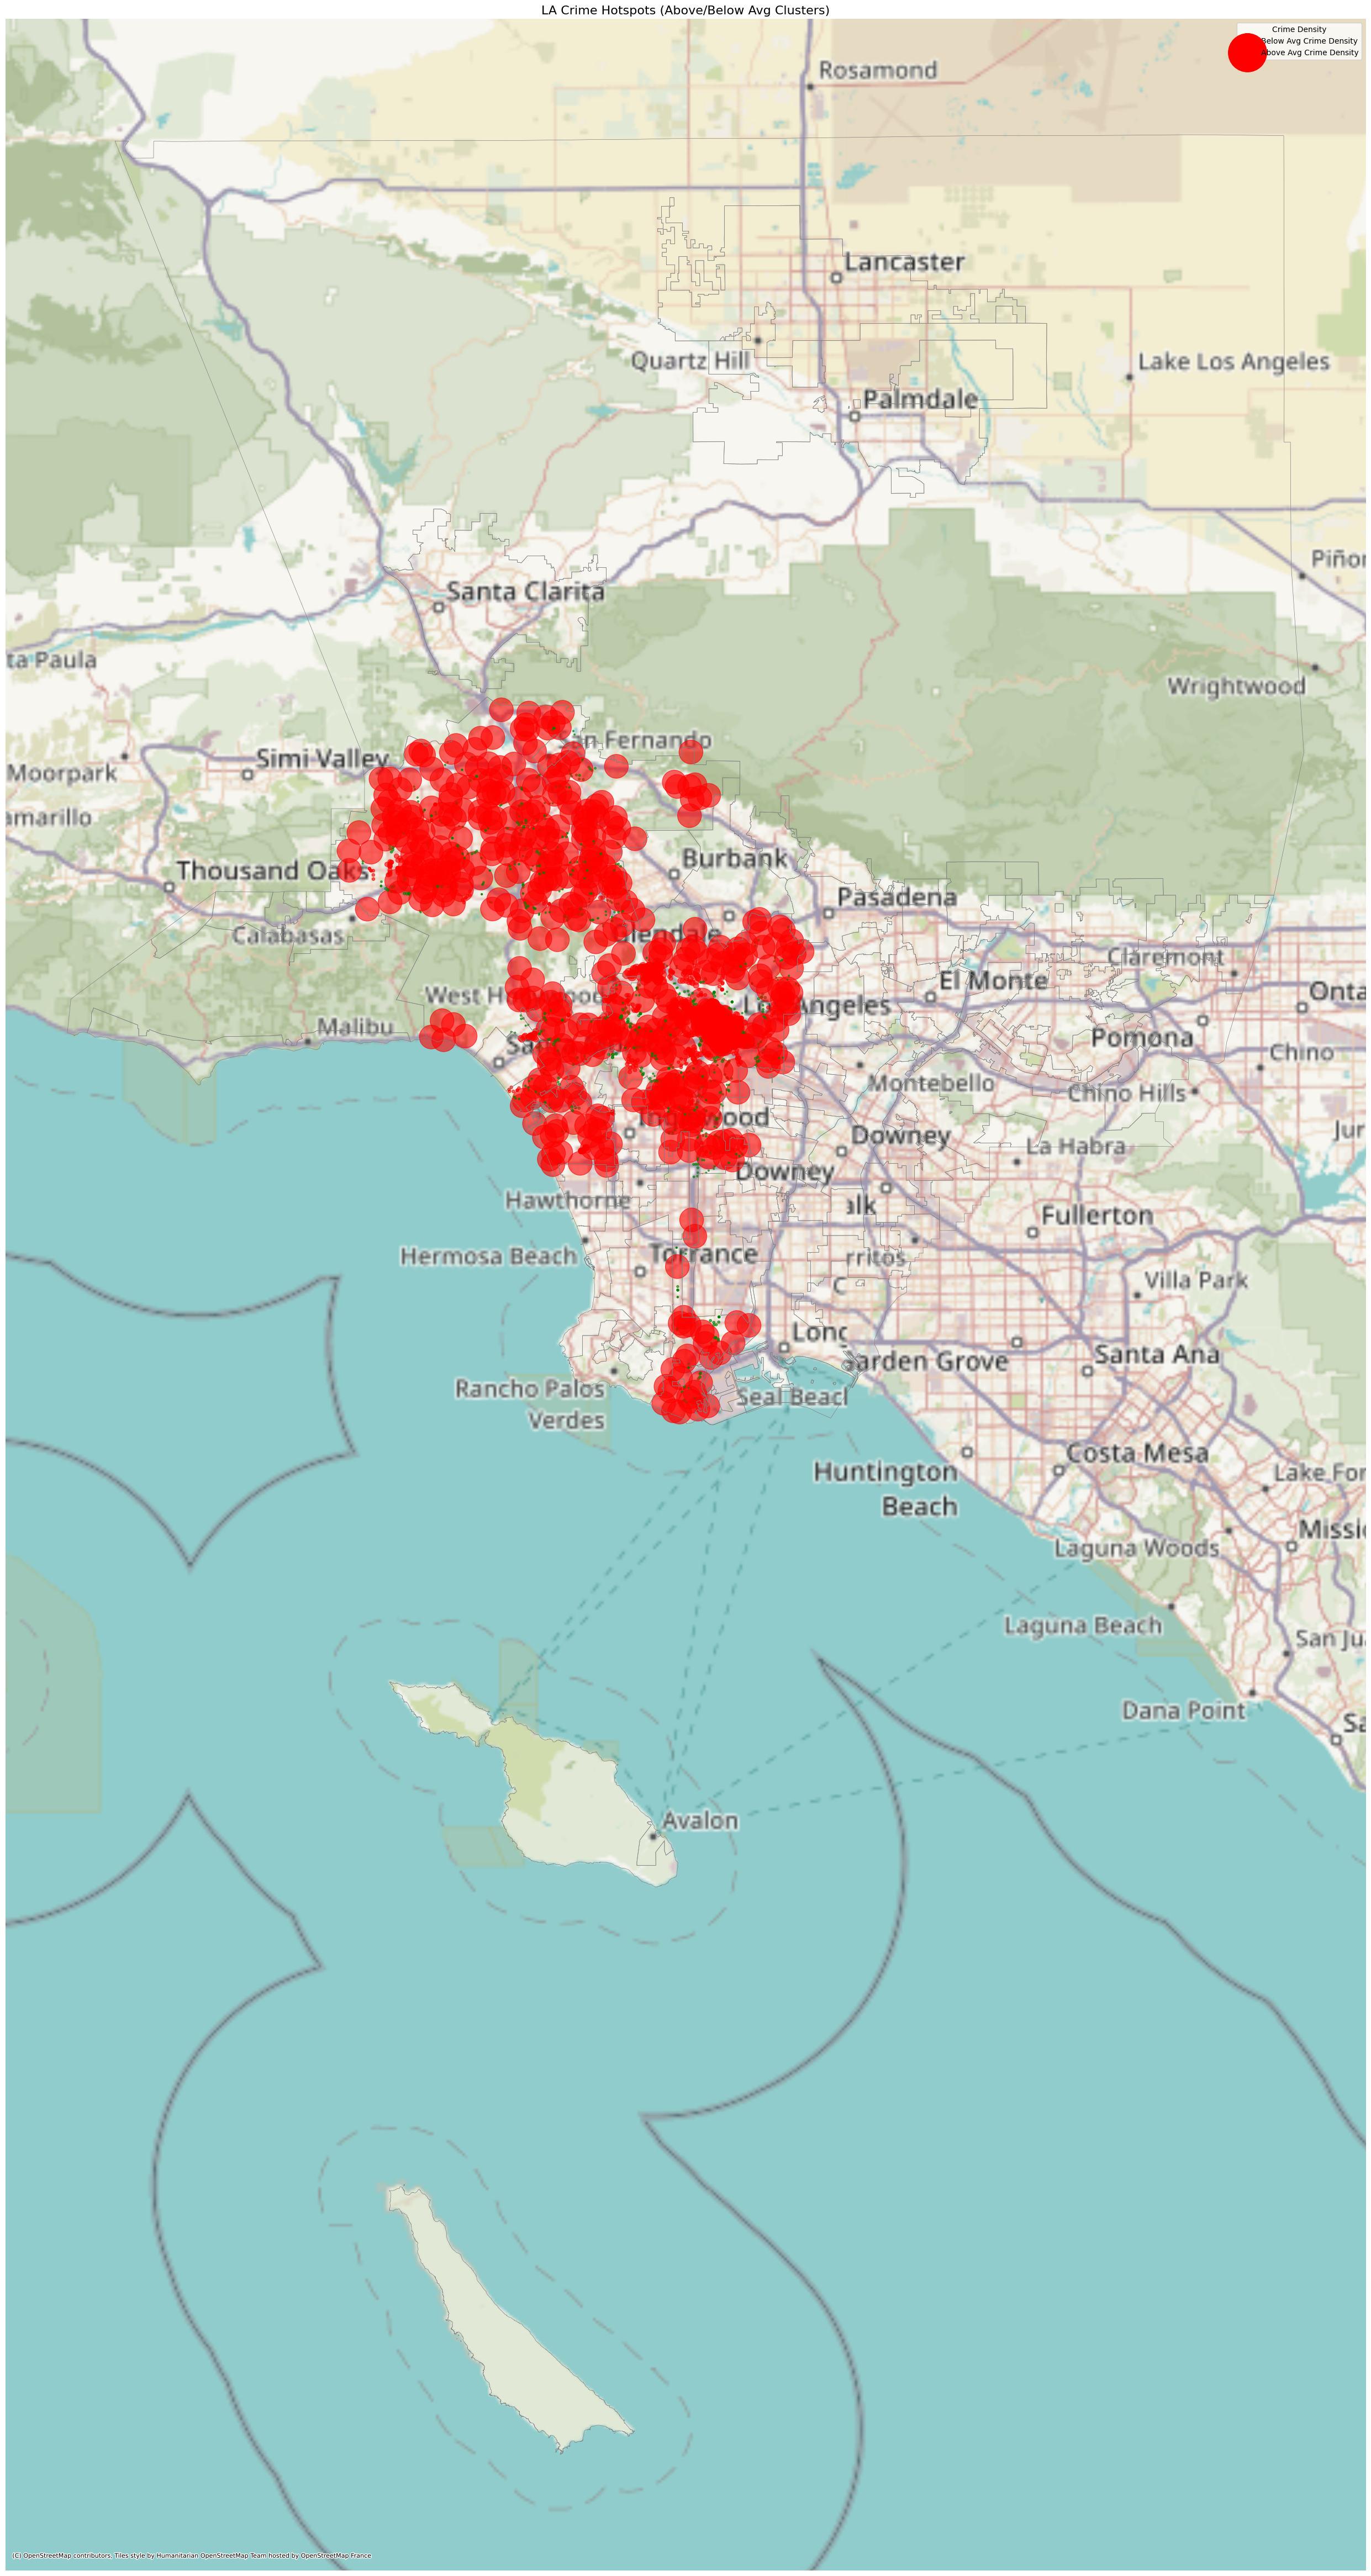

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
import numpy as np
import contextily as ctx
import matplotlib.patches as mpatches

# Step 1: Load Crime Data from multiclass perceptron model
crime_df = cvresults_with_action

# Step 2: Create Geometry from LON/LAT
geometry = [Point(xy) for xy in zip(crime_df['LON'], crime_df['LAT'])]
gdf = gpd.GeoDataFrame(crime_df, geometry=geometry, crs="EPSG:4326")

# Step 3: Load LA Boundary (GeoJSON from ZIP or direct file)
la_boundary = gpd.read_file('City_and_Unincorporated_Boundaries_(Legal).geojson').to_crs(epsg=4326)

# Step 4: Spatial Join (keep only crimes within LA boundary)
gdf_la = gpd.sjoin(gdf, la_boundary, how='inner', predicate='within')

# Step 5: Project to meters for DBSCAN
gdf_la = gdf_la.to_crs(epsg=3857)

# DBSCAN clustering again for completeness
coords = np.array([(point.x, point.y) for point in gdf_la.geometry])
db = DBSCAN(eps=500, min_samples=2).fit(coords)
gdf_la['cluster'] = db.labels_

# Define color map manually (first N clusters + noise)
cluster_labels = sorted(gdf_la['cluster'].unique())
cluster_colors = plt.cm.tab20(np.linspace(0, 1, len(cluster_labels)))

# Step: Plot base map with LA boundary
fig, ax = plt.subplots(figsize=(10, 10))
la_boundary.to_crs(epsg=3857).boundary.plot(ax=ax, edgecolor='gray', linewidth=0.5)

# Plot each cluster separately to control legend
# Aggregate counts per cluster
cluster_counts = gdf_la.groupby('cluster').size().reset_index(name='count')
cluster_by_average = cluster_counts - cluster_counts['count'].mean()

# Merge back to GeoDataFrame
gdf_la = gdf_la.merge(cluster_, on='cluster')

# Plot (all points in same color, size by count)
fig, ax = plt.subplots(figsize=(12, 12))

# Plot LA boundary for context
la_boundary.to_crs(epsg=3857).boundary.plot(ax=ax, edgecolor='gray', linewidth=0.5)

# Plot crime points, size by 'count', same color
gdf_la.plot(ax=ax, markersize=gdf_la['count'], alpha=0.6, color='red')

# Add basemap
ctx.add_basemap(ax, crs=gdf_la.crs)

# Optional: Add a legend proxy to explain dot size meaning
import matplotlib.lines as mlines

size_legend = [
    mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=2, label='Low Crime Density'),
    mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=5, label='High Crime Density')
]

ax.legend(handles=size_legend, title='Crime Density', loc='upper right', size=100)

# Final plot formatting
ax.set_title('LA Crime Hotspots by Density', fontsize=16)
ax.axis('off')
plt.show()

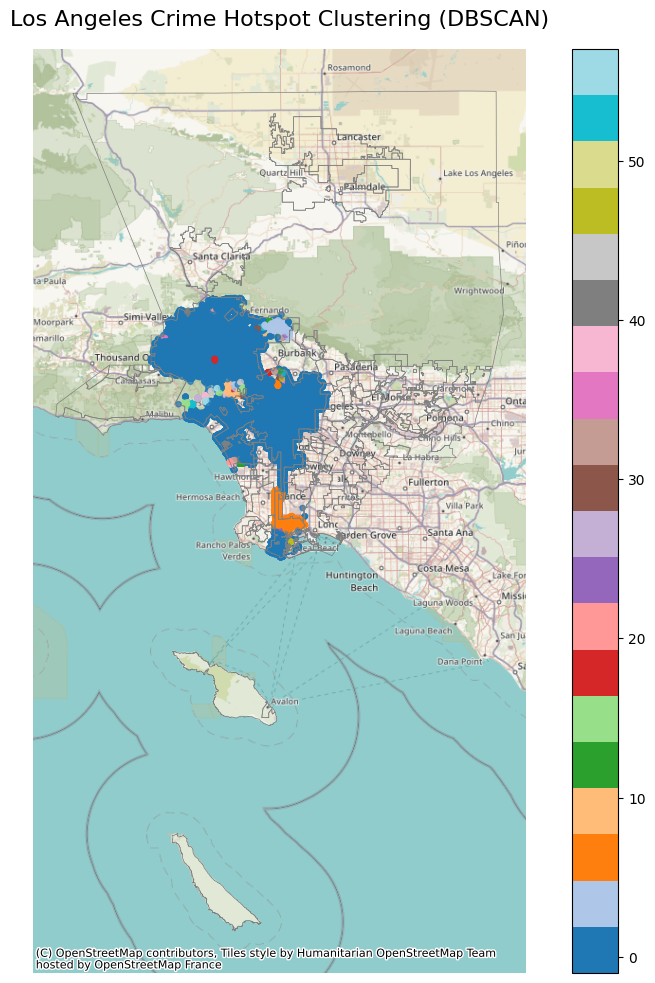

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
import numpy as np
import contextily as ctx

# Step 1: Load Crime Data
crime_df = df_geo_clustered

# Step 2: Create Geometry from LON/LAT
geometry = [Point(xy) for xy in zip(crime_df['LON'], crime_df['LAT'])]
gdf = gpd.GeoDataFrame(crime_df, geometry=geometry, crs="EPSG:4326")

# Step 3: Load LA Boundary (GeoJSON from ZIP or direct file)
la_boundary = gpd.read_file('City_and_Unincorporated_Boundaries_(Legal).geojson').to_crs(epsg=4326)

# Step 4: Spatial Join (keep only crimes within LA boundary)
gdf_la = gpd.sjoin(gdf, la_boundary, how='inner', predicate='within')

# Step 5: Project to meters for DBSCAN
gdf_la = gdf_la.to_crs(epsg=3857)

# Step 6: Extract coordinates for clustering
coords = np.array([(point.x, point.y) for point in gdf_la.geometry])

# Step 7: DBSCAN Clustering
db = DBSCAN(eps=500, min_samples=10).fit(coords)
gdf_la['cluster'] = db.labels_

# Step 8: Plot Clusters with LA boundary & Basemap
fig, ax = plt.subplots(figsize=(12, 12))

# Plot LA Neighborhood Boundaries
la_boundary.to_crs(epsg=3857).boundary.plot(ax=ax, edgecolor='gray', linewidth=0.5)

# Plot Crime Clusters (only LA crimes now)
gdf_la.plot(ax=ax, column='cluster', cmap='tab20', markersize=15, legend=True, alpha=0.7)

# Add basemap tiles
ctx.add_basemap(ax, crs=gdf_la.crs)

# Formatting
plt.title('Los Angeles Crime Hotspot Clustering (DBSCAN)', fontsize=16)
plt.axis('off')
plt.show()


In [ ]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Spark Session
spark = SparkSession.builder.appName("CrimeHotspotStreaming").getOrCreate()

# Simulating stream from folder / Kafka / API
crime_stream_df = spark.readStream.schema("longitude DOUBLE, latitude DOUBLE, crime_type STRING, timestamp TIMESTAMP").json("Crime_Data_from_2020_to_Present_20250510.csv")

# Optional: Filter to LA bounding box to limit scope
crime_stream_df = crime_stream_df.filter(
    (col("longitude") >= -118.67) & (col("longitude") <= -118.16) &
    (col("latitude") >= 33.70) & (col("latitude") <= 34.34)
)

# Output crime stream to in-memory table for micro-batching
query = crime_stream_df.writeStream.format("memory").queryName("crime_data").outputMode("append").start()


Attempted to Update the Mapping for Interactive Map with Spark Streaming - did not succeed but wanted to consider it for future implementations

Spark session stopped.


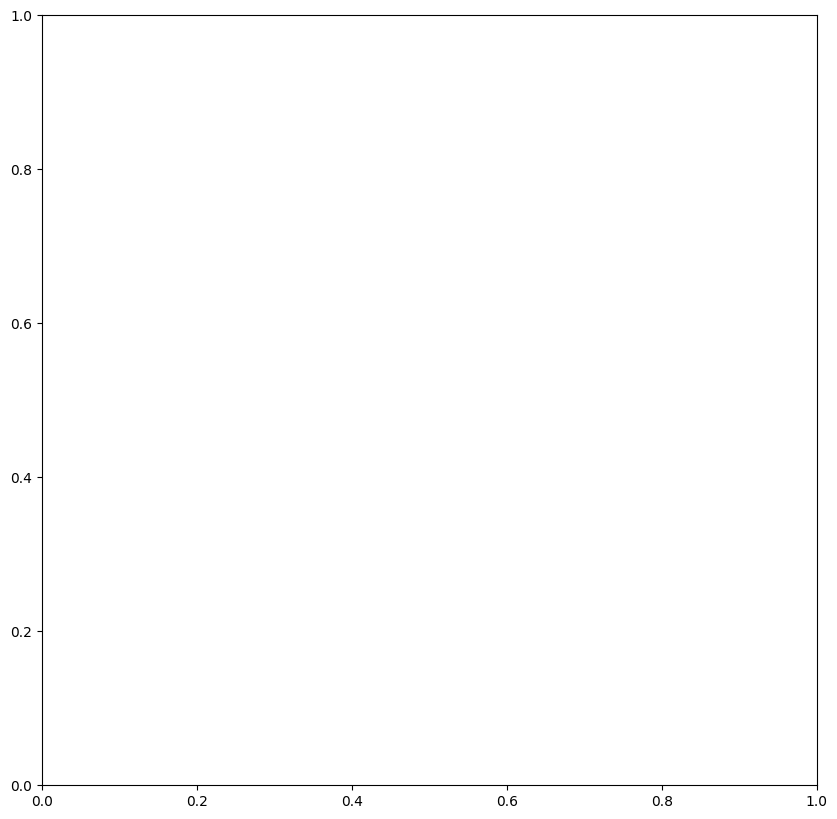

In [ ]:
import time
import pandas as pd
import hdbscan
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

plt.ion()  # Enable interactive mode for live plotting

start_time = time.time()
time_limit = 300  # Stop after 5 minutes

fig, ax = plt.subplots(figsize=(10, 10))  # Persistent figure outside loop

# Load LA boundary once (avoid reloading in every loop)
la_boundary = gpd.read_file('City_and_Unincorporated_Boundaries_(Legal).geojson').to_crs(epsg=3857)

while query.isActive:
    # Time-based stop condition
    if time.time() - start_time > time_limit:
        print("Time limit reached. Stopping stream...")
        query.stop()
        break

    # Pull latest data from Spark
    crime_df = spark.sql("SELECT * FROM crime_data").toPandas()

    if not crime_df.empty:
        # HDBSCAN clustering (Haversine distance)
        coords = crime_df[['longitude', 'latitude']].values
        clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='haversine')
        labels = clusterer.fit_predict(np.radians(coords))

        crime_df['cluster'] = labels

        # Aggregate counts for dynamic sizing
        cluster_counts = crime_df.groupby('cluster').size().reset_index(name='count')

        # Convert to GeoDataFrame for plotting
        gdf = gpd.GeoDataFrame(crime_df, geometry=gpd.points_from_xy(crime_df.longitude, crime_df.latitude), crs="EPSG:4326").to_crs(epsg=3857)

        # Clear previous plot to refresh
        ax.clear()

        # Plot LA boundary
        la_boundary.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.5)

        # Plot clusters with dynamic sizing
        for cluster_id, cluster_data in gdf.groupby('cluster'):
            size = cluster_counts[cluster_counts['cluster'] == cluster_id]['count'].values[0]
            label = 'Noise' if cluster_id == -1 else f'Cluster {cluster_id}'
            cluster_data.plot(ax=ax, markersize=size * 3, alpha=0.7, label=label)

        # Add basemap
        ctx.add_basemap(ax, crs=gdf.crs)

        # Adjust title & legend
        ax.legend(title='Crime Clusters', loc='upper right')
        ax.set_title('Real-time LA Crime Hotspots (HDBSCAN Clustering)', fontsize=14)
        ax.axis('off')

        plt.pause(0.1)  # Pause to render the update without blocking

    # Polling interval
    time.sleep(10)

# Cleanup
spark.stop()
plt.ioff()  # Turn off interactive mode
print("Spark session stopped.")


In [ ]:
import dash
from dash import dcc, html, Output, Input
import plotly.express as px
import pandas as pd
import hdbscan
import numpy as np

# Simulate pulling crime data — replace with Spark SQL query
def get_latest_crime_data():
    # Example DataFrame structure
    # Replace this with: crime_df = spark.sql("SELECT * FROM crime_data").toPandas()
    crime_df = pd.read_csv('Crime_Data_from_2020_to_Present_20250510.csv')  # Example static CSV for demo
    return crime_df

# Run HDBSCAN clustering
def run_hdbscan(crime_df):
    coords = crime_df[['longitude', 'latitude']].values
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='haversine')
    labels = clusterer.fit_predict(np.radians(coords))
    crime_df['cluster'] = labels
    return crime_df

# Dash App
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Real-time LA Crime Hotspots (HDBSCAN Clustering)", style={'textAlign': 'center'}),
    dcc.Graph(id='crime-map'),
    dcc.Interval(id='update-interval', interval=10000, n_intervals=0)  # Update every 10s
])

@app.callback(
    Output('crime-map', 'figure'),
    Input('update-interval', 'n_intervals')
)
def update_crime_map(n):
    # Pull latest crime data (replace with real-time Spark query in production)
    crime_df = get_latest_crime_data()
    if crime_df.empty:
        return dash.no_update

    # Run HDBSCAN clustering
    clustered_df = run_hdbscan(crime_df)

    # Aggregate crime counts per cluster
    cluster_counts = clustered_df.groupby('cluster').size().reset_index(name='count')
    clustered_df = clustered_df.merge(cluster_counts, on='cluster')

    # Prepare map figure
    fig = px.scatter_mapbox(
        clustered_df,
        lat="latitude",
        lon="longitude",
        color="cluster",
        size="count",
        size_max=30,
        zoom=10,
        height=700,
        mapbox_style="carto-positron",
        title="Live Crime Hotspots in Los Angeles"
    )

    return fig

if __name__ == '__main__':
    app.run(debug=True)


<IPython.core.display.Javascript object>